# Topic Modelling using LDA

## Objective
The dataset includes approximately 5000 articles along with their id's. In the analysis below the topics and the tone of the articles is identified from  the raw unstructured text.

## Assumptions/ Understanding:
The provided dataset is a list of the lead articles (articles viewed by users) during the test period of recommendation algorithms. 

## Insights
 Some of the interesting insights observed about data from exploratory analysis and topic modelling are:

Topic Modelling:
* Most of the  articles are focussed around Government, Finance and Countries.
* More than 70% of the articles includes 'say', 'said', 'saying' as one of the top words along with the source name, which means they could be either directly from the source or third party.

Tone Analysis:
* Of the total 4984 articles, more than 3000 articles use positive vocabulary
* People generally prefer reading short articles < 500 words.

Named Entity Recognition:
* President Donald Trump was one of the most viewed articles as he was mentioned in around 392 articles.

In [186]:
# Import all the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Exploration

Load the dataset in pandas to understand the variables present in it

In [187]:
# Read the dataset and display the first few rows.

lead_article=pd.read_csv('lead_article_text.csv')
lead_article.head()

,id,txt
0,USBRE85909D20120610,Three men including two former Auburn Universi...
1,USFWN1JI0QE,EIFFAGE: * WINS €190 MILLION CONTRACT TO BUILD...
2,USKCN0HW09X20141007,A California oyster farm has settled its years...
3,USN2038388620070721,Screeners at U.S. airports will stop confiscat...
4,USKBN0UC1O020151229,A federal judge granted approval for coal prod...


In [188]:
# Check the information and the null values in the dataset

lead_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
id     5000 non-null object
txt    4984 non-null object
dtypes: object(2)
memory usage: 78.2+ KB


In [189]:
lead_article.isnull().sum()

id      0
txt    16
dtype: int64

As seen from the above information there are 5000 id values but only 4984 txt data which means there are some missing values in the txt column of the dataset, which needs to be handled.
Since the null values are very few and no other information about those id's to see if the null values are representing any pattern ,removing these rows from the dataset.

In [190]:
# Removing the null values from dataset

lead_article.dropna(inplace=True)

In [191]:
# check the dataset again after removal to see if there are no more null values.

lead_article.isnull().sum()

id     0
txt    0
dtype: int64

## Text Pre-Processing

Since, text in the article would be in the unstructured form, various types of noise would be present in it, so it needs some pre processing to make the data analyzable.
Few steps followed for this:
* Noise Removal
* Lexicon Normalization

### Noise Removal
Removing the stop words, punctuations from the dataset using an inbuild nltk library and regular expressions

In [192]:
# import the libraries 

import nltk # Import the stop word library from python Natural Language Toolkit
nltk.download()
from nltk.corpus import stopwords # Import the stop word list
import re # Import regular expression library to find and replace the words
import string 

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [193]:
# Function to convert uncleaned text to a string of text
# 1. Remove non letters
# 2. Change everything to lowercase
# 3. Remove stopwords

def cleanup_text(txt):
    letters = re.sub("[^a-zA-Z]", " ", txt) # Remove anything in the sentence other than letters
    words = letters.lower().split()   # change everything to lowercase
    noise_list=['say', 'saying', 'said', 'says'] # added few more words in noise list as observed while analyzing the data
    stops = set(stopwords.words("english")) # convert to a set for faster processing
    meaningful_words = [w.strip() for w in words if w not in stops and w not in noise_list]   # remove the stop words
    sentence = " ".join( meaningful_words )  # join back all the remaining words into sentence separated by a space
    return sentence.strip()

In [194]:
# apply the cleanup_test function to all the txt articles

lead_article['clean_text']=lead_article['txt'].apply(cleanup_text)
lead_article.head()

,id,txt,clean_text
0,USBRE85909D20120610,Three men including two former Auburn Universi...,three men including two former auburn universi...
1,USFWN1JI0QE,EIFFAGE: * WINS €190 MILLION CONTRACT TO BUILD...,eiffage wins million contract build new headqu...
2,USKCN0HW09X20141007,A California oyster farm has settled its years...,california oyster farm settled years long laws...
3,USN2038388620070721,Screeners at U.S. airports will stop confiscat...,screeners u airports stop confiscating common ...
4,USKBN0UC1O020151229,A federal judge granted approval for coal prod...,federal judge granted approval coal producer w...


### Lexicon Normalization - Lemmatization
As the dataset includes the articles text there would be various different variations of a word, hence using lemmatization to further clean the text and obtain the root word from those words.

In [195]:
from nltk.stem.wordnet import WordNetLemmatizer 
lem = WordNetLemmatizer()

In [196]:
def lem_word(clean_text):
    words=clean_text.split()
    root_word=[lem.lemmatize(word,"v") for word in words]
    sentence = " ".join(root_word)
    return sentence.strip()

In [197]:
# apply the lemmatize function to all the txt articles

lead_article['clean_text']=lead_article['clean_text'].apply(lem_word)
lead_article.head()

,id,txt,clean_text
0,USBRE85909D20120610,Three men including two former Auburn Universi...,three men include two former auburn university...
1,USFWN1JI0QE,EIFFAGE: * WINS €190 MILLION CONTRACT TO BUILD...,eiffage win million contract build new headqua...
2,USKCN0HW09X20141007,A California oyster farm has settled its years...,california oyster farm settle years long lawsu...
3,USN2038388620070721,Screeners at U.S. airports will stop confiscat...,screeners u airports stop confiscate common ci...
4,USKBN0UC1O020151229,A federal judge granted approval for coal prod...,federal judge grant approval coal producer wal...


### Feature Engineering : Text to features
Since the text is now cleaned, applying feature engineering on data to analyze the text.

### Word length in articles
Average word  length in the articles is around 250 words.Very few articles have word length greater than 500 words.

In [198]:
def length(clean_text):
    return len(clean_text.split(' '))

In [199]:
lead_article['word_length']=lead_article['clean_text'].apply(length)

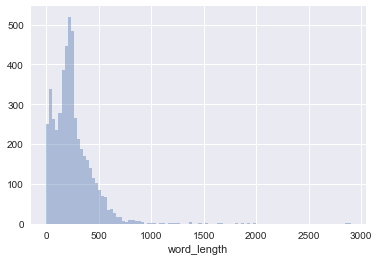

In [200]:
sns.distplot(lead_article['word_length'],kde=False, bins=100)

In [201]:
def a_type(clean_text):
    if len(clean_text.split(' '))<=20:
        return 'Heading'
    elif len(clean_text.split(' '))>20 and len(clean_text.split(' '))<=500:
        return 'Short Article'
    return 'Article'

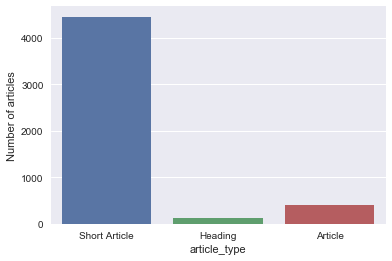

In [202]:
lead_article['article_type']=lead_article['clean_text'].apply(a_type)
sns.countplot(x='article_type', data =lead_article).set( ylabel='Number of articles')

### Topic Modelling
Applying Latent Dirchilent Allocation (LDA) model to obtain the topics from the articles.

The LDA model works with the Bag of Words(bow) vectorizer but since bow uses the frequency of the words in a document and doesn't penalize the word which appears a lot.Hence, this could be improved by first applying the tf-idf vectorization and converting it into raw numbers and then using LDA with bag of words over it. After applying the LDA, most of the topics included the word 'say', hence included its different variations in the noise_list above to further clean the text.

In [203]:
import gensim

In [204]:
from gensim import corpora

In [206]:
# Applying LDA model and obtaining the topics from the corpus

doc_clean=[doc.split() for doc in lead_article['clean_text']] 
dictionary = corpora.Dictionary(doc_clean)
dictionary.save('dictionary.dict')
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=30)
loading=ldamodel.save('topic.model')
#print(ldamodel.print_topics(num_topics=3, num_words=5))
t=[]
for topic in ldamodel.show_topics(num_topics=10, formatted=False, num_words=6):
    #print("Topic {}: ".format(topic[0]))
    topicwords = [w for (w,val) in topic[1]]
    for word in topicwords:
        t.append(word)
    print topicwords

[u'new', u'build', u'air', u'project', u'aircraft', u'land']
[u'percent', u'year', u'price', u'oil', u'market', u'u']
[u'china', u'company', u'plant', u'year', u'power', u'market']
[u'people', u'one', u'year', u'police', u'two', u'kill']
[u'store', u'percent', u'food', u'amazon', u'brand', u'online']
[u'health', u'study', u'use', u'people', u'drug', u'percent']
[u'court', u'u', u'case', u'rule', u'federal', u'law']
[u'u', u'state', u'trump', u'president', u'would', u'unite']
[u'company', u'bank', u'billion', u'fund', u'million', u'share']
[u'rat', u'fitch', u'report', u'debt', u'term', u'bank']


### WordCloud
Representing the word cloud to show some of the top words in the articles considered for topics.

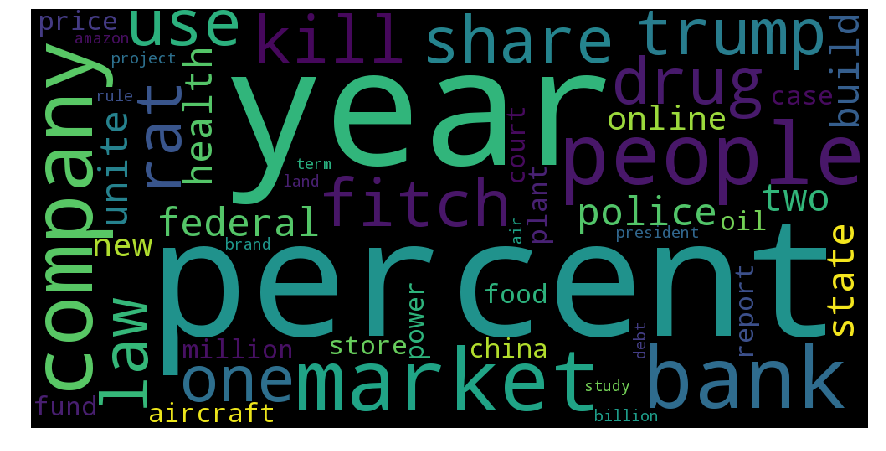

In [207]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(t))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Top words in different topics
The plot below shows the top words present in different topics.

In [208]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [209]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [210]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      20.252484        1       1 -0.074740  0.006538
1      14.964025        1       2 -0.033288 -0.000961
3      14.874547        1       3  0.144645  0.027208
6      11.837325        1       4  0.027298  0.148474
7      11.508015        1       5  0.107972  0.149446
5       7.660569        1       6  0.007881 -0.047221
2       7.105012        1       7  0.047499 -0.048478
0       4.195303        1       8  0.067348 -0.050513
9       4.139376        1       9 -0.290704  0.063854
4       3.463344        1      10 -0.003911 -0.248346, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
44881  Default  7117.000000     percent  7117.000000  30.0000  30.0000
42376  Default  2082.000000         rat  2082.000000  29.0000  29.0000
1467   Default  6929.000000     company  6929.000000  28.0000  28.0000
32086  Default  1850.000000       court  1850.000000  27.0000  27.0000
61     Default  2805.000000       china  2805.000000  26.0000  26.0000
25163  Default  4495.000000        bank  4495.000000  25.0000  25.0000
42902  Default  1744.000000       trump  1744.000000  24.0000  24.0000
40831  Default  1895.000000         oil  1895.000000  23.0000  23.0000
17197  Default  4505.000000     billion  4505.000000  22.0000  22.0000
25977  Default  2834.000000       price  2834.000000  21.0000  21.0000
7474   Default   858.000000       fitch   858.000000  20.0000  20.0000
6789   Default  6788.000000           u  6788.000000  19.0000  19.0000
37052  Default  3968.000000      market  3968.000000  18.0000  18.0000
12781  Default  3130.000000        fund  3130.000000  17.0000  17.0000
5980   Default  2612.000000        deal  2612.000000  16.0000  16.0000
22524  Default  1253.000000        debt  1253.000000  15.0000  15.0000
21001  Default   840.000000      health   840.000000  14.0000  14.0000
11514  Default  3083.000000      people  3083.000000  13.0000  13.0000
9815   Default   639.000000       store   639.000000  12.0000  12.0000
9317   Default  1559.000000        case  1559.000000  11.0000  11.0000
40745  Default  2662.000000       share  2662.000000  10.0000  10.0000
38861  Default  4707.000000       state  4707.000000   9.0000   9.0000
12773  Default  2380.000000        firm  2380.000000   8.0000   8.0000
16328  Default  2028.000000         inc  2028.000000   7.0000   7.0000
39626  Default   934.000000       study   934.000000   6.0000   6.0000
11149  Default  1997.000000   financial  1997.000000   5.0000   5.0000
40927  Default  1246.000000       build  1246.000000   4.0000   4.0000
30908  Default  3346.000000      report  3346.000000   3.0000   3.0000
15074  Default  1344.000000       sales  1344.000000   2.0000   2.0000
15314  Default   731.000000        food   731.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
7195   Topic10    81.336741  restaurant    99.621358   3.1602  -6.2793
7389   Topic10   152.910784    retailer   214.130667   3.0262  -5.6480
22044  Topic10    46.548162        apps    53.241078   3.2286  -6.8374
10490  Topic10    80.188935     organic   106.961856   3.0748  -6.2935
15314  Topic10   359.148218        food   731.658379   2.6514  -4.7942
41988  Topic10   297.657845       brand   592.500986   2.6745  -4.9820
43664  Topic10    62.995986   radiation    79.107354   3.1352  -6.5348
712    Topic10   186.069049       chain   334.568929   2.7762  -5.4518
552    Topic10   260.672913      online   558.527293   2.6009  -5.1146
12748  Topic10   142.096666       whole   306.339073   2.5948  -5.7214
14132  Topic10   154.626058         com   389.095997   2.4401  -5.6369
4774   Topic10   146.446709           e   388.912739   2.3862  -5.6912
36391  Topic10   160.976530       india   490.996292   2.2478  -5.5966
27712  Topic10    74.252498         eat   1

### Sentiment Analysis
Inorder to obtain the tone of the article, using Sentiment analysis to see which type of articles are most frequently read.

In [211]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(clean_text):
    clean_text = [clean_text]
    sid = SentimentIntensityAnalyzer()
    for sentence in clean_text:
        #print(sentence)
        ss = sid.polarity_scores(sentence)
        if ss['compound']>0:
            return "positive"
        elif ss['compound']==0:
            return "neutral"
        return "negative"

In [212]:
# apply the sentiment function to all the txt articles 

lead_article['sentiment'] = lead_article['clean_text'].apply(sentiment)
lead_article.head()

,id,txt,clean_text,word_length,article_type,sentiment
0,USBRE85909D20120610,Three men including two former Auburn Universi...,three men include two former auburn university...,235,Short Article,negative
1,USFWN1JI0QE,EIFFAGE: * WINS €190 MILLION CONTRACT TO BUILD...,eiffage win million contract build new headqua...,19,Heading,positive
2,USKCN0HW09X20141007,A California oyster farm has settled its years...,california oyster farm settle years long lawsu...,195,Short Article,positive
3,USN2038388620070721,Screeners at U.S. airports will stop confiscat...,screeners u airports stop confiscate common ci...,127,Short Article,negative
4,USKBN0UC1O020151229,A federal judge granted approval for coal prod...,federal judge grant approval coal producer wal...,227,Short Article,positive


In [213]:
lead_article['sentiment'].value_counts()

positive    3161
negative    1730
neutral       93
Name: sentiment, dtype: int64

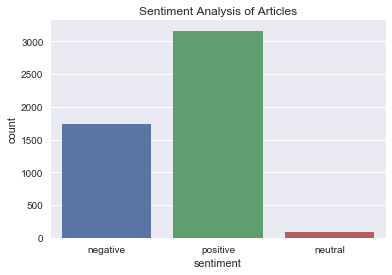

In [214]:
sns.countplot(x="sentiment", data=lead_article).set(title='Sentiment Analysis of Articles')

Sentiment analyzer shows most of the articles use positive vocabulary 

### TO DO future tasks:
* Applying tf-idf vectorization to further improve the list of words used for topic modelling
* Further improvements on the sentiment analysis.
* Implementing Named Entity recognition for Entity extraction to identify the top names (people, companies, location, countries) mentioned in the articles.